In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..") ## resetting the path to the parent directory

In [2]:
from src.pipeline import *

In [3]:
from src.url_csv import df_join
from src.plots import roc_auc_plot

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, auc, plot_roc_curve
from sklearn.metrics import RocCurveDisplay
import eli5
import warnings

warnings.filterwarnings("ignore")

/Users/anotherjonlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/anotherjonlee/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import random

random.seed(42)

## Data Preparation

In [7]:
df1 = pd.read_csv('../data/ht_match.csv')
df2 = pd.read_csv('../data/ht_match_ind.csv')

df = df_join(df1,df2)

In [8]:
y = df['win']

X = df.drop(columns=['match_id','win'])

#### Converting boolean columns into a numeric columns

In [9]:
mask = {'blue':0,'red':1}
X['teams'] = X['teams'].replace(mask)
X[['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron','firstDragon', 'firstRiftHerald']] = 1* X[['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron','firstDragon', 'firstRiftHerald']]

In [10]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

## Pipeline

In [11]:
num_features, cat_features = feature_separator(X)

In [12]:
scaled_pl = pipeline(True,num_features,False, True)
unscaled_pl = pipeline(True,num_features,False, False)

In [13]:
lrc_s = append_model(LogisticRegression(), scaled_pl)
lrc_u = append_model(LogisticRegression(), unscaled_pl)

rfc_s = append_model(RandomForestClassifier(n_jobs = -1), scaled_pl)
rfc_u = append_model(RandomForestClassifier(n_jobs = -1), unscaled_pl)

gbc_s = append_model(GradientBoostingClassifier(), scaled_pl)
gbc_u = append_model(GradientBoostingClassifier(), unscaled_pl)

abc_s = append_model(AdaBoostClassifier(), scaled_pl)
abc_u = append_model(AdaBoostClassifier(), unscaled_pl)

nbc_s = append_model(GaussianNB(), scaled_pl)
nbc_u = append_model(GaussianNB(), unscaled_pl)

## Establishing an initial base model without any feature engineering 

In [14]:
clfs = {'scaled log reg': lrc_s,
        'unscaled random forest': rfc_u,
        'scaled gradient boost': gbc_s,
        'scaled gradient boost': abc_s,
        'scaled Bayesian': nbc_s}

model_scorer(clfs,X_train,y_train,X_validation,y_validation)

Mean cross validatin score for scaled log reg: 0.89
Precision score for scaled log reg: 0.92
Recall score for scaled log reg: 0.87


Mean cross validatin score for unscaled random forest: 0.90
Precision score for unscaled random forest: 0.90
Recall score for unscaled random forest: 0.90


Mean cross validatin score for scaled gradient boost: 0.89
Precision score for scaled gradient boost: 0.91
Recall score for scaled gradient boost: 0.88


Mean cross validatin score for scaled Bayesian: 0.84
Precision score for scaled Bayesian: 0.86
Recall score for scaled Bayesian: 0.83




## Comparing ROC AUC Curves for base models

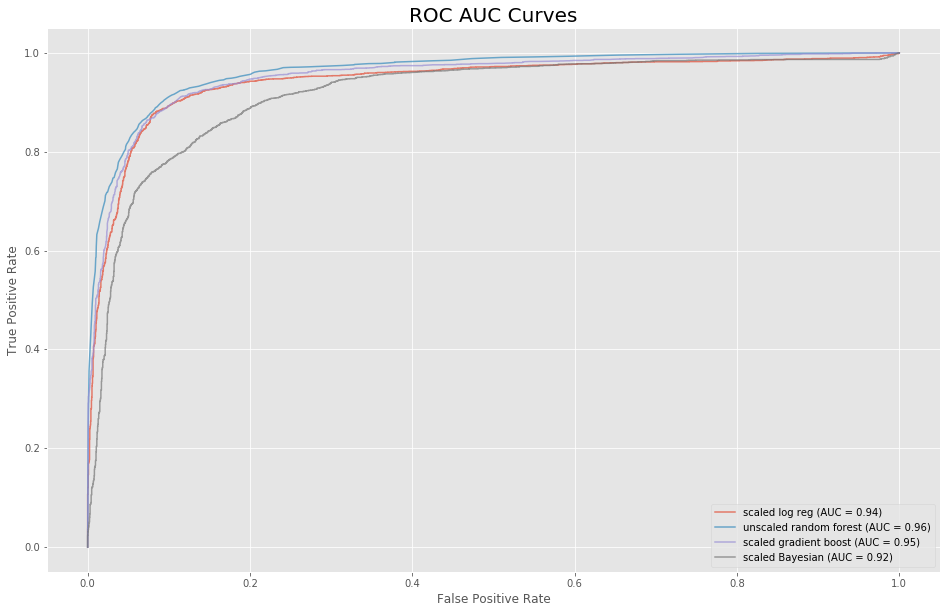

In [15]:
fig,ax = plt.subplots(figsize=(16,10))

roc_auc_plot(ax, clfs, X_train, y_train, X_validation, y_validation)

## Feature engineering with a chosen model

##### Feature importances

In [16]:
#onehot_cols = list(lrc_s.named_steps['transformer'].named_transformers_['categorical'].named_steps['encoder'].get_feature_names())
numeric_cols = list(num_features)
#numeric_cols.extend(onehot_cols)

In [17]:
lrc_s.named_steps['estimator'].coef_

array([[ 0.00928542,  0.1497674 ,  0.68285522,  1.81828427,  0.84479274,
         0.39892017,  0.06795635, -2.18350983, -1.93987946,  3.229938  ,
         0.51944494, -0.37382494, -0.06700957]])

In [19]:
weight_explainer(lrc_s,num_features)

Weight?,Feature
+3.230,xp
+1.818,firstInhibitor
+0.845,firstBaron
+0.683,firstTower
+0.519,totalKills
+0.399,firstDragon
+0.364,<BIAS>
+0.150,firstBlood
+0.068,firstRiftHerald
+0.009,teams


In [22]:
weight_explainer(rfc_u,num_features)

Weight,Feature
0.3207 ± 0.1939,firstInhibitor
0.1343 ± 0.1473,firstTower
0.0818 ± 0.0540,totalDeaths
0.0804 ± 0.0479,totalGold
0.0750 ± 0.0443,level
0.0739 ± 0.0361,xp
0.0660 ± 0.0899,firstBaron
0.0570 ± 0.0470,totalKills
0.0456 ± 0.0303,level_ups
0.0278 ± 0.0522,firstDragon


## Tuning hyperparameters

## Confusion Matrix results